[55.31 46.31 42.0 37.81 33.44 30.0 27.0 25.31 21.5 19.19]
0.9445011750938154
Die Fitparameter für die Steigung ist m = -0.088 +- 0.008
Die Fitparameter für den y-Achsenabschnitt ist c = 49.9 +- 1.66


'\nfrom scipy.stats import linregress\nFit_results = linregress(Abstand_Sensoren.astype(float),Temperatur.astype(float))\n\ngradient, intercept, r_value, p_value, std_err_slope = linregress(Abstand_Sensoren.astype(float),Temperatur.astype(float))\n'

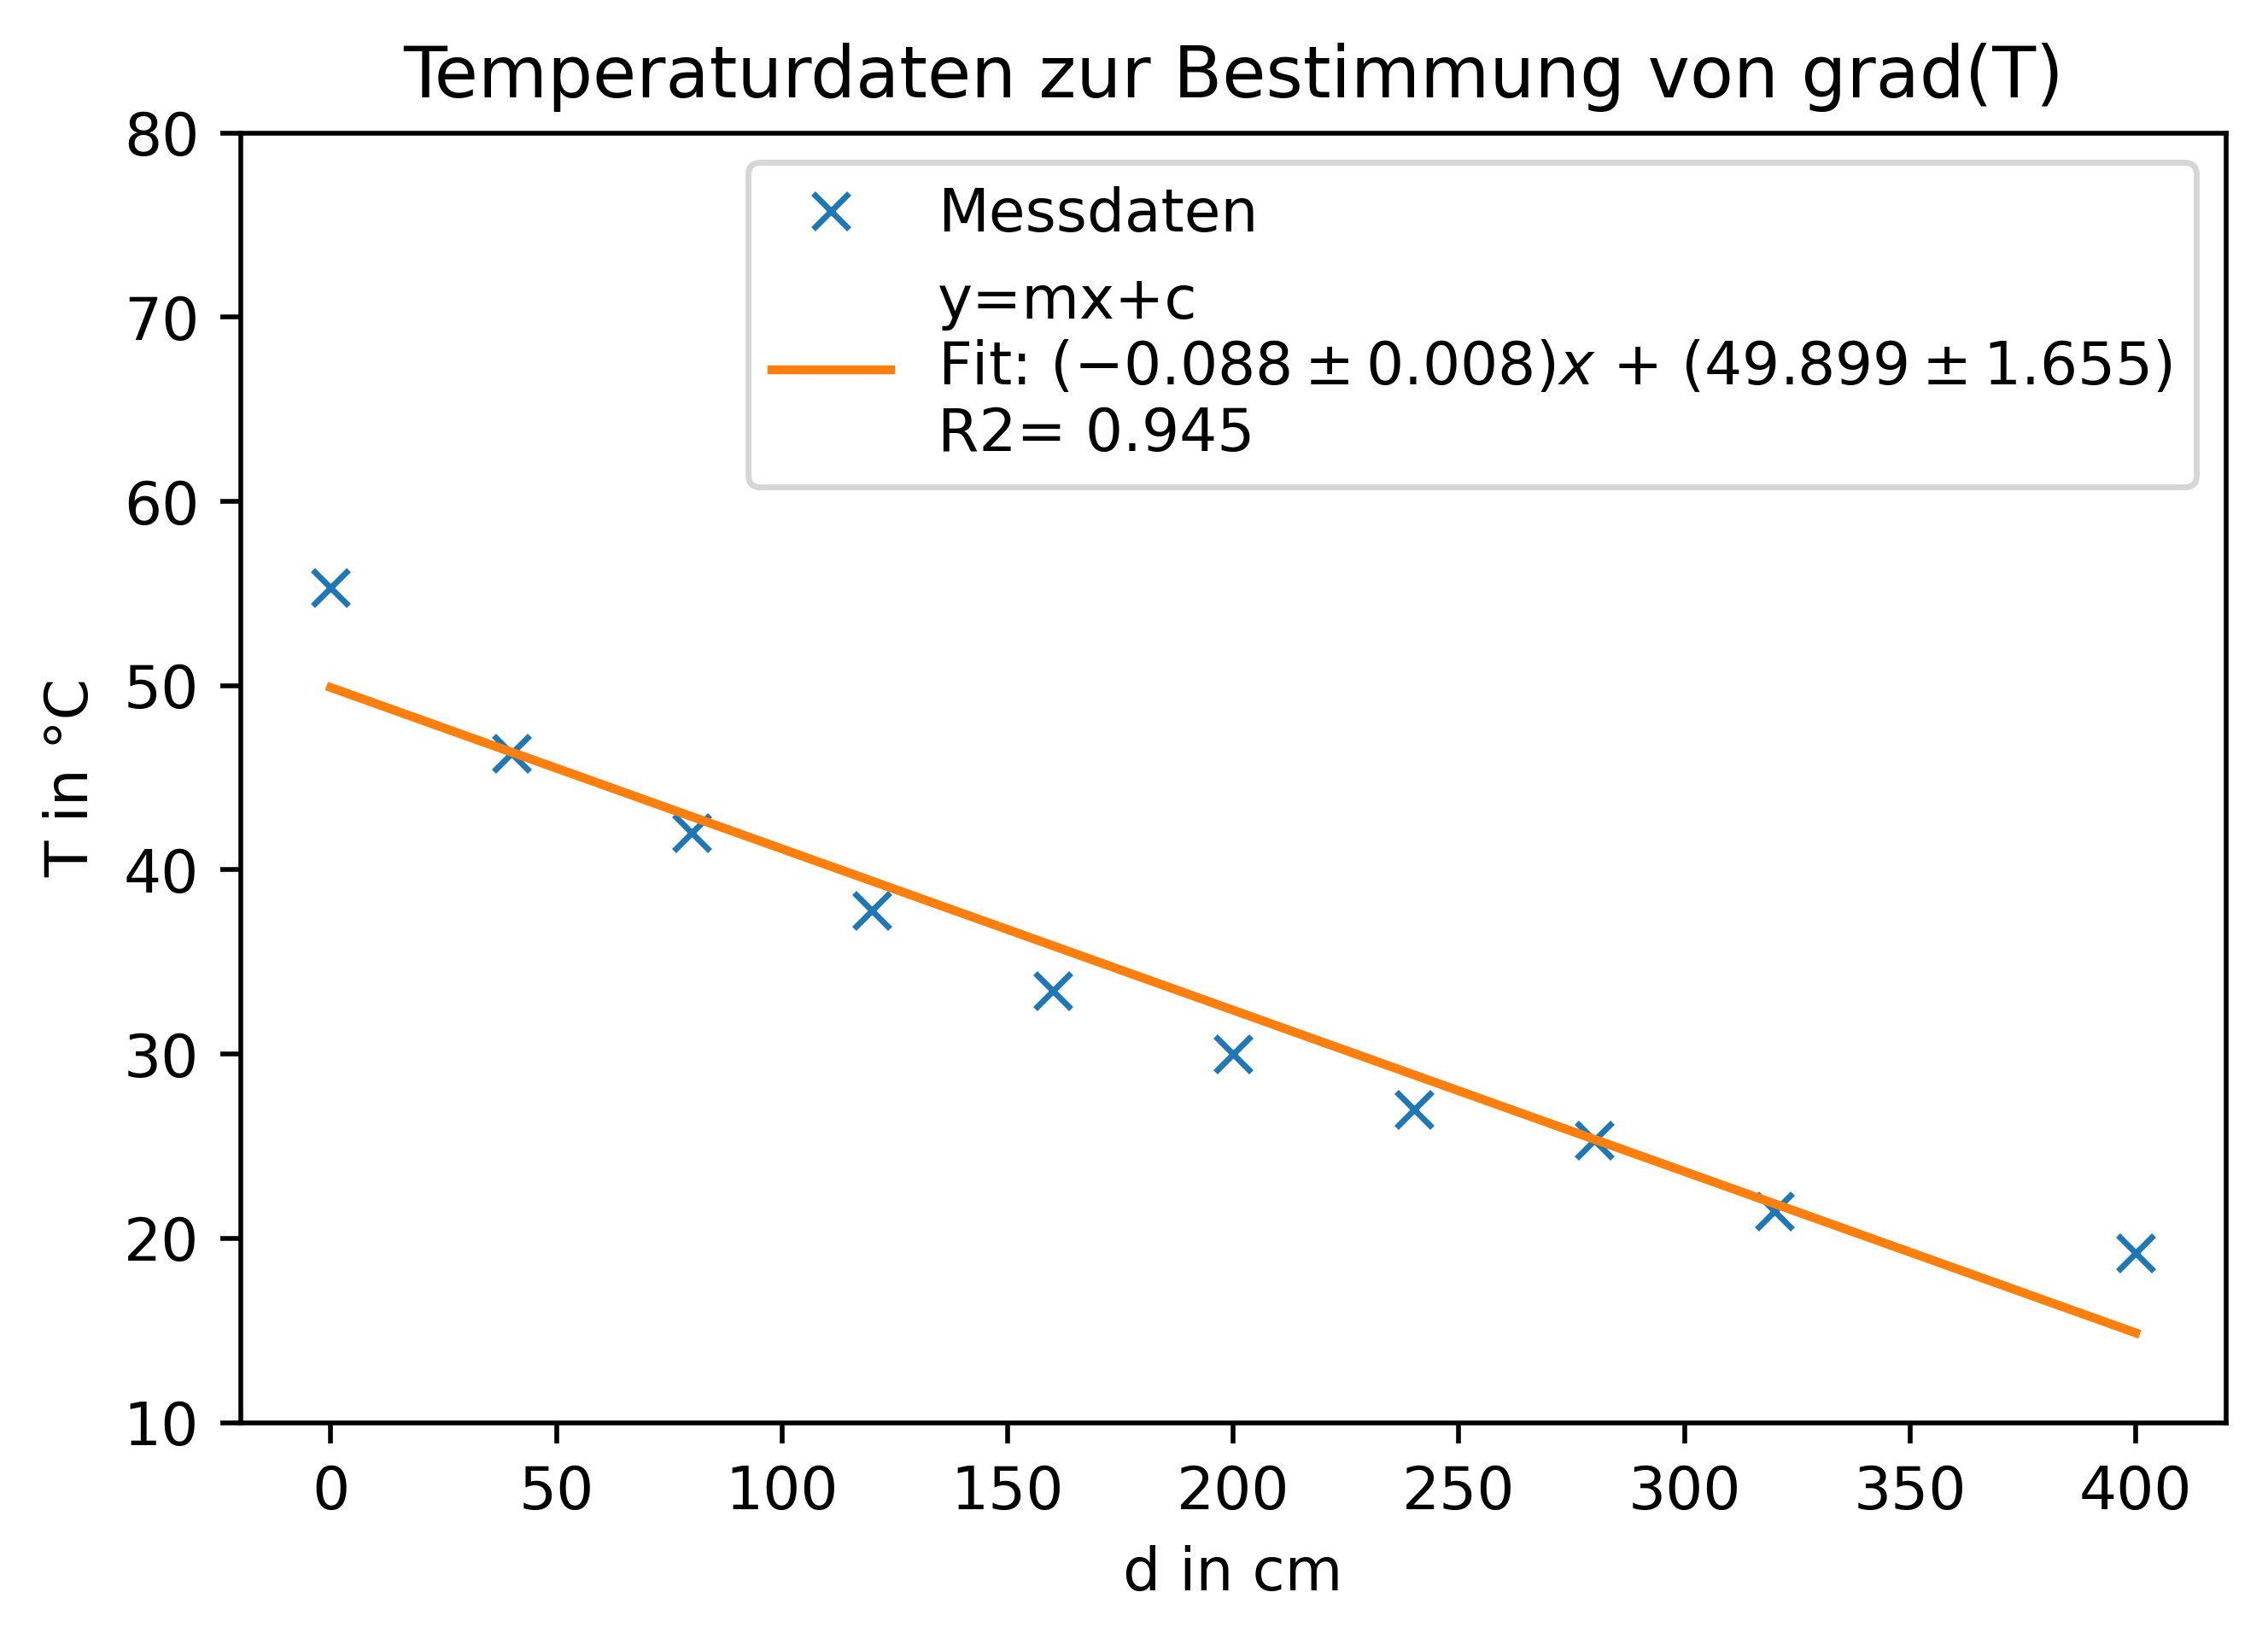

In [20]:
#Importiere die benötigten Bibliotheken

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime
#from lmfit import Model

df=pd.read_csv("Temperaturdaten.txt",sep='[;, ]',header=None,skiprows=3,engine='python')#Lese die Temperaturdaten ein, Lege keinen Header fest und überspringe 3 Zeilen

df.columns=['Datum','Zeit','Sensor1','Sensor2','Sensor3','Sensor4','Sensor5','Sensor6','Sensor7','Sensor8','Sensor9','Sensor10'] #Neuen Header festlegen

df_numpy=df.values  #Forme Datenframe in Numpy array um

#zeit=pd.to_datetime(df['Zeit'],format='%d.%m.%Y%H:%M:%S.%f').to_numpy()#.astype('datetime64')  #Forme die Spalte, in welcher die Zeit steht in ein Datetimeobjekt und dann in ein Numpy datetime64 Objekt
zeit=pd.to_datetime(df['Zeit']).to_numpy()#.astype('datetime64')  #Forme die Spalte, in welcher die Zeit steht in ein Datetimeobjekt und dann in ein Numpy datetime64 Objekt

#Abstand_Sensoren=np.linspace(0,36,10) #Definiere den Abstand der Sensoren, hier bitte darauf achten dass diese zum Versuchsaufbau passen
Abstand_Sensoren=np.array([0,40,80,120,160,200,240,280,320,400])



Start=zeit[0,].copy() #Erstelle eine echte Kopie 0. Eintrags des Arrays zeit und definiere diesen als Startwert
Ende=np.shape(zeit)[0] #Der Endwert wird benötigt, damit die Zeitdifferenz zum Startwert berechnet werden kann
Zeit_neu=np.empty(Ende) # Hilfsvariable Zeit_neu
i=1
while i<Ende: #Die While-Schleife erstellt den Array Zeit neu, damit wir nun die vergangenen Sekunden ab Start haben
   Zeit_neu[i-1]= (zeit[i]- Start)/np.timedelta64(1,'s')
   i+=1
    
Zeit_neu=np.round(Zeit_neu,3) # Runde Sekunden auf Millisekunden



#Suche Index, wo gewünschte das erste Mal Zeit erreicht ist
Zeitsuche_minutes=15
Zeitsuche=Zeitsuche_minutes*60
Zeitindex=np.where((Zeit_neu>Zeitsuche))[0][0]

#Gebe die Temperaturdaten bei gefundenem Zeitindex aus
#print(df.iloc[Zeitindex,2:10])
Temperatur=df_numpy[Zeitindex,2:12]
print(Temperatur)

#Stelle die Messdaten im Graphen dar
fig, ax1=plt.subplots(1,1,sharey=True)
plt.rcParams['figure.dpi'] = 800  #Vergrößere auf 300 dpi
ax1.plot(Abstand_Sensoren,Temperatur,'x',label='Messdaten')
ax1.set_title('Temperaturdaten zur Bestimmung von grad(T)')
ax1.set_xlabel('d in cm')
ax1.set_ylabel('T in °C')
ax1.set_ylim(10,80)

#Führe den Fit durch und erstelle mir eine Funktion in Form einer Geraden
def Temperaturfuntkion(Abstand_Sensoren,Steigung,y_Achsenabschnitt):
    return Steigung*Abstand_Sensoren + y_Achsenabschnitt

#Führe den Fit nach der Methode der kleinsten Quadrate aus
popt,pcov=curve_fit(Temperaturfuntkion,Abstand_Sensoren,Temperatur,[-1,50]) #-1,50 sind die Startwerte für Steigung und y-Achsenabschnitt

#Bestimme das R^2=1-(Residual Sum of Squares)/(Total Sum of Squars). Das R^2 gibt an, wie gut der Fit bzw. unsere Funktion zu den Daten passt
residuals=Temperatur -Temperaturfuntkion(Abstand_Sensoren,*popt) #Bestimme die Residuen, die Abweichung von der Amplitude zur Fitfunktion
Res_square=np.sum(residuals**2) #Quadrat der Residuen
ss_tot=np.sum((Temperatur -np.mean(Temperatur))**2) # Bestimmte die totale Quadratsumme  
R2=1-Res_square/ss_tot #Bestimmte das R^2




#plt.plot(Abstand_Sensoren, Temperaturfuntkion(Abstand_Sensoren,*popt),label='y=mx+c \nFit: m=%5.3f, c=%5.3f ' % tuple(popt)) #plotte die Zeit gegen die Fitfunktion. Das Label benötigen wir später für die Anzeige einer Legende im Graphen
ax1.plot(Abstand_Sensoren, Temperaturfuntkion(Abstand_Sensoren,*popt),label=(r'y=mx+c'+'\n'+r'Fit: $(%5.3f \pm %5.3f)x$ + $(%5.3f  \pm %5.3f)$' +'\n' +'R2= %5.3f' ) % (popt[0],np.sqrt(pcov[0][0]),popt[1],np.sqrt(pcov[1][1]),R2)) #plotte die Zeit gegen die Fitfunktion. Das Label benötigen wir später für die Anzeige einer Legende im Graphen



ax1.legend() #Stelle die Legende im Graphen dar

print(R2)
print('Die Fitparameter für die Steigung ist m = {} +- {}'.format(round(popt[0],3),round(np.sqrt(pcov[0][0]),3)))
print('Die Fitparameter für den y-Achsenabschnitt ist c = {} +- {}'.format(round(popt[1],2),round(np.sqrt(pcov[1][1]),2)))




# Fitmethode nach lmfit Modul. Besser als Curvefit und enthält Chi^2 etc.
'''

def Linreg(x, m, c,):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (m*x+c)


gmodel = Model(Linreg)
result = gmodel.fit(Temperatur, x=Abstand_Sensoren, m=-1, c=70)

#params = gmodel.make_params(cen=0.3, amp=3, wid=1.25)

print((gmodel.param_names, gmodel.independent_vars))
print(result.fit_report())

#print(gmodel.guess(y,x))  # Only for built in models

ax2.plot(Abstand_Sensoren, Temperatur, 'o')
ax2.plot(Abstand_Sensoren, result.init_fit, '--', label='initial fit')
ax2.plot(Abstand_Sensoren, result.best_fit, '-', label='best fit')
ax2.set_xlabel('d in cm')
ax2.set_ylabel('T in °C')
ax1.set_ylim(10,80)


ax2.legend()
plt.show()



### Archiv Befehle

#k=map(lambda x: datetime.datetime.strptime(x,'%H:%M:%S.%f'),df['Zeit'])
#Zeit=np.array(list(k))
#df.at[3,'Zeit']

'''
'''
from scipy.stats import linregress
Fit_results = linregress(Abstand_Sensoren.astype(float),Temperatur.astype(float))

gradient, intercept, r_value, p_value, std_err_slope = linregress(Abstand_Sensoren.astype(float),Temperatur.astype(float))
'''

